In [ ]:
import torch
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import html
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_frame=pd.read_csv("/content/drive/MyDrive/gradproj/DataSet.csv")
# Assuming 'label' is the column with your target classes
data_frame.dropna()
class_distribution = data_frame['label'].value_counts()
# Print the distribution
print(class_distribution)
print(data_frame.shape)


label
0.0    581037
1.0    123908
Name: count, dtype: int64
(705069, 2)


In [ ]:
data_frame2=pd.read_csv("/content/drive/MyDrive/gradproj/pro.csv")
data_frame2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  20001 non-null  object
 1   tagging   20001 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
data_frame2.rename(columns={"tagging":"label"},inplace=True)
data_frame2.rename(columns={"comments":"text"},inplace=True)

In [ ]:

# Assuming 'label' is the column with your target classes
data_frame2.dropna()
class_distribution2 = data_frame2['label'].value_counts()
# Print the distribution
print(class_distribution2)
print(data_frame2.shape)

label
0    12179
1     7822
Name: count, dtype: int64
(20001, 2)


In [ ]:
# Combine the datasets
combined_df = pd.concat([data_frame, data_frame2], ignore_index=True)

Shape of the combined dataset: (725070, 2)
Shape of the balanced dataset: (526920, 2)
label
1.0    263460
0.0    263460
Name: count, dtype: int64


<ipython-input-43-2959b5de1bf7>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution3.index, y=class_distribution3.values, palette='viridis')


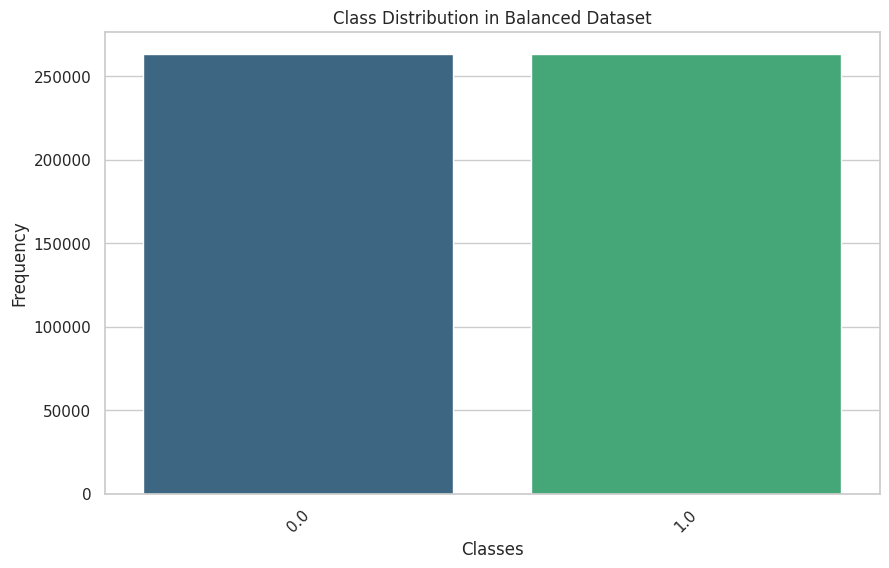

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
# Display the shape of the combined dataset
print("Shape of the combined dataset:", combined_df.shape)

# Separate classes
class_0 = combined_df[combined_df['label'] == 0]
class_1 = combined_df[combined_df['label'] == 1]

# Determine the target size for balancing
target_size = min(len(class_0), len(class_1) * 2)  # For example, upsample class 1 to twice its original size

# Oversample the minority class to the target size
class_1_oversampled = resample(class_1,
                               replace=True,  # Sample with replacement
                               n_samples=target_size,  # Target size
                               random_state=42)  # Reproducible results

# Undersample the majority class to the target size
class_0_undersampled = resample(class_0,
                                replace=False,  # Sample without replacement
                                n_samples=target_size,  # Target size
                                random_state=42)  # Reproducible results

# Combine the resampled classes into a balanced DataFrame
balanced_df = pd.concat([class_0_undersampled, class_1_oversampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Display the shape of the balanced dataset
print("Shape of the balanced dataset:", balanced_df.shape)

# Save the balanced data to a CSV file
balanced_df.to_csv('/content/drive/MyDrive/balanced_data.csv', index=False)
class_distribution3 = balanced_df['label'].value_counts()
# Print the distribution
print(class_distribution3)
# Plot the class distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.barplot(x=class_distribution3.index, y=class_distribution3.values, palette='viridis')
plt.title('Class Distribution in Balanced Dataset')  # Title of the plot
plt.xlabel('Classes')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the class names if needed

# Show the plot
plt.show()

<ipython-input-44-8f33bf272361>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_class_distribution.index, y=original_class_distribution.values, palette='viridis', ax=ax[0])
<ipython-input-44-8f33bf272361>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_class_distribution.index, y=balanced_class_distribution.values, palette='viridis', ax=ax[1])


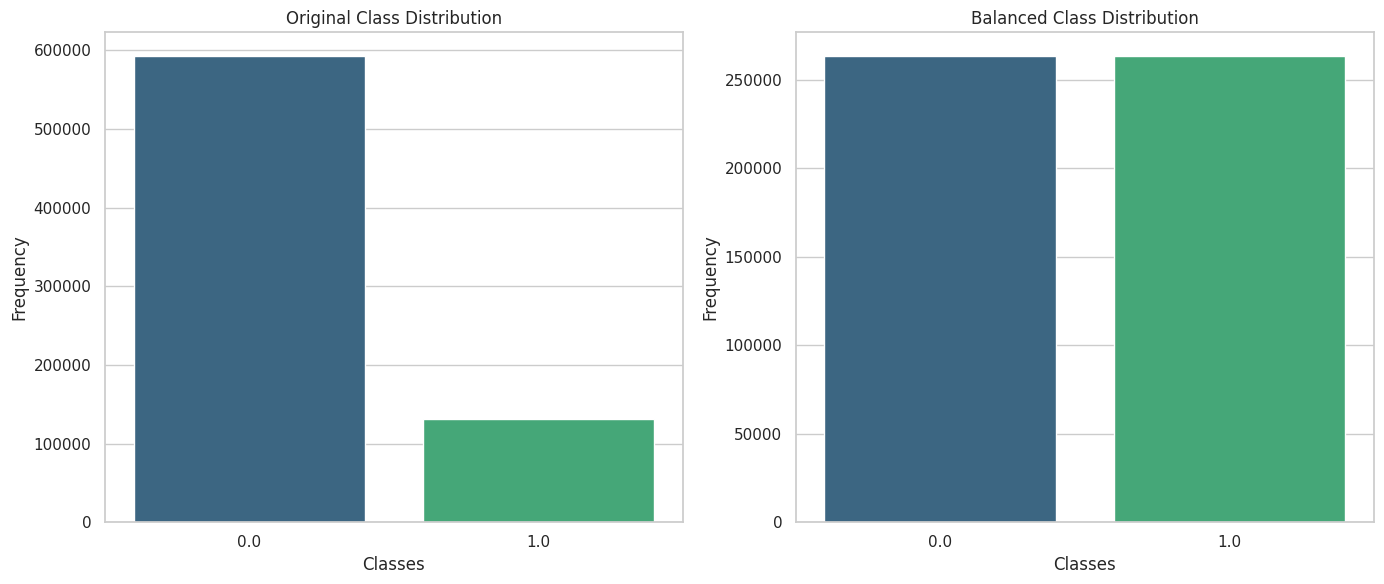

In [ ]:
# Original class distribution
original_class_distribution = combined_df['label'].value_counts()

# Balanced class distribution
balanced_class_distribution = balanced_df['label'].value_counts()

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=original_class_distribution.index, y=original_class_distribution.values, palette='viridis', ax=ax[0])
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Frequency')

sns.barplot(x=balanced_class_distribution.index, y=balanced_class_distribution.values, palette='viridis', ax=ax[1])
ax[1].set_title('Balanced Class Distribution')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Split the balanced dataset to get 120,000 entries for training
train_df, remaining_df = train_test_split(balanced_df, train_size=120000, random_state=42, stratify=balanced_df['label'])

# Split the remaining dataset to get another 200,000 entries for the new file
subset_200k_df, extra_df = train_test_split(remaining_df, train_size=200000, random_state=42, stratify=remaining_df['label'])

# Display the shape of the split datasets
print("Shape of the training dataset:", train_df.shape)
print("Shape of the extra dataset:", extra_df.shape)
print("Shape of the 200k subset dataset:", subset_200k_df.shape)

# Save the training data to a CSV file
train_df.to_csv('/content/drive/MyDrive/training_data.csv', index=False)

# Save the extra data to a CSV file
extra_df.to_csv('/content/drive/MyDrive/extra_data.csv', index=False)

# Save the 200k subset data to a CSV file
subset_200k_df.to_csv('/content/drive/MyDrive/subset_200k_data.csv', index=False)

Shape of the training dataset: (120000, 2)
Shape of the extra dataset: (206920, 2)
Shape of the 200k subset dataset: (200000, 2)
